# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv1_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version:    2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [2]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions


In [3]:
import scooby # Reports Python environment

In [4]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz']))


--------------------------------------------------------------------------------
  Date: Wed Oct 12 17:29:04 2022 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.5.0
          pyincore : 1.7.0
      pyincore_viz : Version unknown
             numpy : 1.23.3
             scipy : 1.9.1
           IPython : 8.5.0
        matplotlib : 3.6.0
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [5]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [6]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/
'''
communities = {'Mobile_AL' : {
                    'community_name' : 'Mobile, AL',
                    'STATE' : 'ALABAMA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '01097', 'Name' : 'Mobile County, AL'}}}}
'''


communities = {'SLC_UT' : {
                    'community_name' : 'Salt Lake City, UT',
                    'STATE' : 'UTAH',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '49035', 'Name' : 'Salt Lake City County, UT'}}}}

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [7]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0


In [8]:
# create data_service object for loading files
data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

Generating Housing Unit Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Salt Lake City, UT: 0
Dataset Housing Unit Inventory v2.0.0 data for Salt Lake City, UT does not exist in IN-CORE
Salt Lake City County, UT : county FIPS Code 49035

***************************************
    Version control - list of installed packages
***************************************

# packages in environment at c:\Users\nathanael99\Miniconda3\envs\pyincore20220926:
#
# Name                    Version                   Build  Channel
affine                    2.3.1              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb82d6ee_2    conda-forge
asttokens                 2.0.8              pyhd8ed1ab_0    conda-forge
attrs                     22.1.0             py

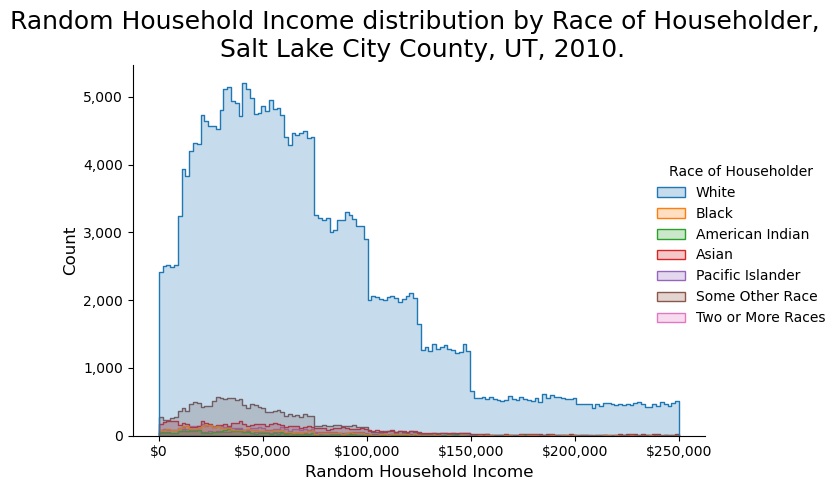

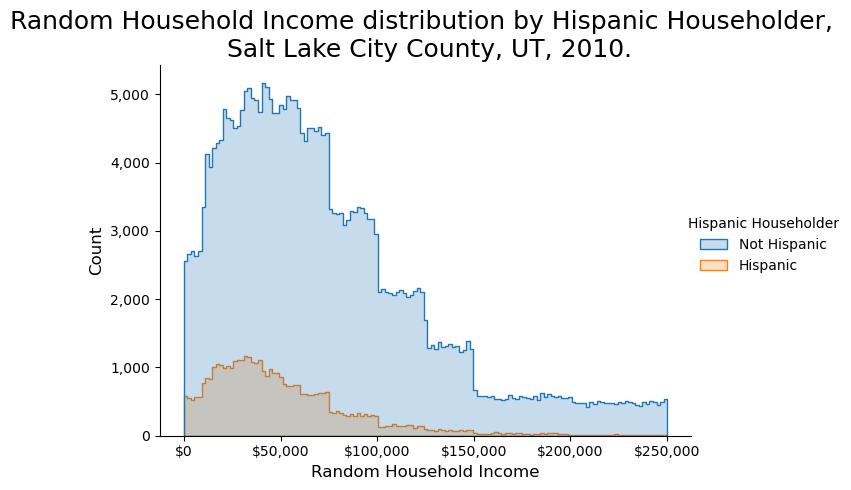

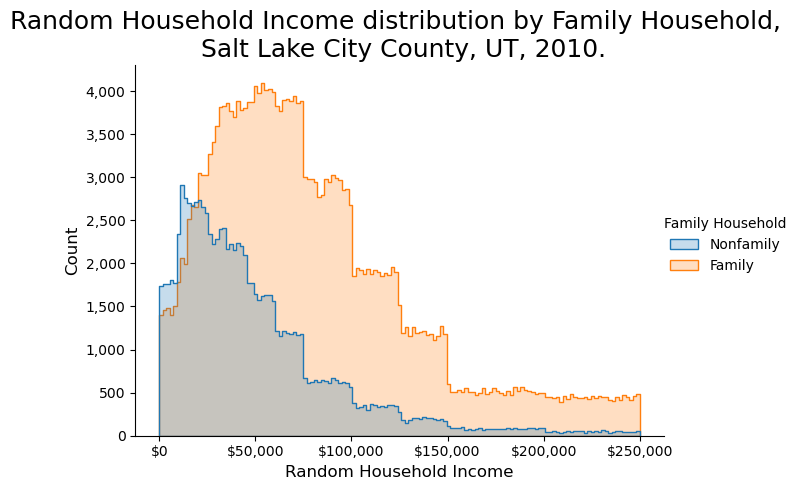

In [9]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

In [10]:
# Housing Unit inventory
housing_unit_inv_id = hui_dataset_id
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\6347400aedc16c0e577d65de\hui_v2-0-0_SLC_UT_2010_rs1000\hui_v2-0-0_SLC_UT_2010_rs1000.csv


In [11]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")

In [12]:
housing_unit_inv_df['huid'].describe()

count                   364210
unique                  364210
top       B490351001001006H001
freq                         1
Name: huid, dtype: object

## Read in Building Inventory

In [13]:
# Building inventory
bldg_inv_id = "62fea288f5438e1f8c515ef8" # SLC building inventory - Milad Roohi
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\62fea288f5438e1f8c515ef8\Salt Lake County All Building\Salt Lake County All Building.shp


In [14]:
bldg_inv_gdf = gpd.read_file(filename)
# Check CRS of building inventory
bldg_inv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
from pyproj import CRS
# Update CRS to EPSG:4326 if not already in that format
if bldg_inv_gdf.crs != CRS.from_epsg(4326):
    bldg_inv_gdf = bldg_inv_gdf.to_crs(epsg=4326)
    print("The CRS of the building inventory has been updated to EPSG:4326")
else:
    print("The CRS of the building inventory is already in EPSG:4326")

The CRS of the building inventory is already in EPSG:4326


In [16]:
# Check Unique ID
bldg_inv_gdf[['guid','bldg_id']].astype(str).describe().T

,count,unique,top,freq
guid,284925,284925,6f8c3468-4696-4371-bc91-3a7ceec1e768,1
bldg_id,284925,112,16200000000000.0,17249


In [17]:
bldg_inv_gdf.head(1).T

,0
parid,28200000000000.0
parid_card,28200000000000.0
bldg_id,28200000000000.0
struct_typ,RM1L
archetype,COM3
str_prob,None
year_built,1993
no_stories,1
a_stories,None
b_stories,None


In [18]:
# What variable has information to determine if building is residential or not?
# County observations by variable
bldg_inv_gdf[['archetype','occ_type','guid']].groupby(['archetype','occ_type']).count()

,,guid
archetype,occ_type,
AGR1,AGR1,57
COM1,COM1,7900
COM10,COM10,373
COM2,COM2,4674
COM3,COM3,2096
COM4,COM4,5674
COM5,COM5,270
COM6,COM6,217
COM7,COM7,421


#### HAZUS Occupancy Status
Table 3-1: Hazus Occupancy Class Definitions

| Label             | Hazus Occupancy Class            |
|-------------------|----------------------------------|
|                   | Residential                      |
| RES1              | Single Family Dwelling           |
| RES2              | Mobile / Manufactured Home       |
| RES3A            | RES3A Duplex                      |
| RES3B            | RES3B 3-4 Units                   |
| RES3C  |  5-9 Units                 |
| RES3D  |  10-19 Units                         |
| RES3E  |   20-49 Units                      |
| RES3F |   50+ Units                       |
| RES4              | Temporary Lodging                |
| RES5              | Institutional Dormitory          |
| RES6              | Nursing Home                     |
|-------|------------------------------------|
|                   | Commercial                       |
| COM1              | Retail Trade                     |
| COM2              | Wholesale Trade                  |
| COM3              | Personal and Repair Services     |
| COM4              | Professional/Technical Services  |
| COM5  | Banks                              |
| COM6  | Hospital                           |
| COM7  | Medical Office/Clinic              |
| COM8  | Entertainment & Recreation         |
| COM9  | Theaters                           |
| COM10 | Parking                            |
|------|------------------------|
|       | Industrial                         |
|------|------------------------|
| IND1  | Heavy                              |
| IND2  | Light                              |
| IND3  | Food/Drugs/Chemicals               |
| IND4  | Metals/Minerals Processing         |
| IND5  | High Technology                    |
| IND6  | Construction                       |
|------|------------------------|
|       | Agriculture                        |
|------|------------------------|
| AGR1  | Agriculture                        |
|       | Religion/Membership Organizations  |
| REL1  | Church/Nonprofit                   |
|------|------------------------|
|       | Government                         |
|------|------------------------|
| GOV1  | General Services                   |
| GOV2  | Emergency Response                 |
|------|------------------------|
|      | Education              |
|------|------------------------|
| EDU1 | Grade School, Library  |
| EDU2 | College/University     |


### Find Spatial Extent of Building Inventory
Need to know which counties are included in the building inventory.

In [19]:
#map = viz.plot_gdf_map(bldg_inv_gdf,column='dlevel')
#map

#### Use Tract ID to find county FIPS code
The first 5 digits of the tract ID are the FIPS code for the county.

In [20]:
bldg_inv_gdf['tract_id'].describe()

count    2.849250e+05
mean     4.903511e+10
std      4.125693e+03
min      4.903510e+10
25%      4.903511e+10
50%      4.903511e+10
75%      4.903511e+10
max      4.903511e+10
Name: tract_id, dtype: float64

In [21]:
# Substring of tractid to get county 5 digit fips code 
# covert tract_id to string with leading zeros
bldg_inv_gdf['tract_id_str'] = bldg_inv_gdf['tract_id'].astype(str).str.zfill(11)
bldg_inv_gdf['county'] = bldg_inv_gdf['tract_id_str'].str[:5]
bldg_inv_gdf[['tract_id_str','county']].describe()

,tract_id_str,county
count,284925,284925
unique,193,1
top,49035113104,49035
freq,8331,284925


### Building Inventory File has 1 county
The Salt Late City building inventory only has 1 county.

## Generate Address Point Inventory


In [22]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

HAZUS_residential_archetypes = { 
    "RES1" : "Single Family Dwelling",
    "RES2" : "Mobile / Manufactured Home",
    "RES3A" : "Duplex",
    "RES3B" : "3-4 Units",
    "RES3C" : "5-9 Units",
    "RES3D" : "10-19 Units",
    "RES3E" : "20-49 Units",
    "RES3F" : "50+ Units",
    "RES4" : "Temporary Lodging",
    "RES5" : "Institutional Dormitory",
    "RES6" : "Nursing Home"
    }

residential_archetypes = HAZUS_residential_archetypes 

In [23]:
for community in communities.keys():
    print("Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        archetype_var = 'archetype',
                        building_area_var = 'sq_foot',
                        building_area_cutoff = 300,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

Address point inventory for: SLC_UT
Based on building inventory: 62fea288f5438e1f8c515ef8
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Address Point Inventory v2.0.0 data for Salt Lake City, UT: 0
Dataset Address Point Inventory v2.0.0 data for Salt Lake City, UT does not exist in IN-CORE
***************
Obtaining Census Block, Place, and PUMA Data
***************

File already exists: c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data/OutputData/tl_2010_SLC_UT_tabblockplacepuma10EPSG4269.csv
Converting blk104269 to Geodataframe
***************
Predicting Housing Unit Estimates
***************

File already existsc:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\Replicat

### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [24]:
print(addpt_dataset_id)

63474044edc16c0e577d65e3


In [25]:
# Check if addpt_dataset_id is string
if isinstance(addpt_dataset_id, str):
    print("The Address Point Inventory ID is a pandas string")
    # Address Point inventory
    addpt_inv_id = addpt_dataset_id
    # load housing unit inventory as pandas dataframe
    addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
    filename = addpt_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
    addpt_inv_df = pd.read_csv(filename, header="infer")
# else if addpt_dataset_id is a dataframe
elif isinstance(addpt_dataset_id, pd.DataFrame):
    addpt_inv_df = addpt_dataset_id
    print("The Address Point Inventory ID contains a pandas dataframe")
else:
    print("The Address Point Inventory is not a string or pandas dataframe")

The Address Point Inventory ID is a pandas string
The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63474044edc16c0e577d65e3\addpt_v2-0-0_SLC_UT_2010_62fea288f5438e1f8c515ef8\addpt_v2-0-0_SLC_UT_2010_62fea288f5438e1f8c515ef8.csv


In [26]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                             491867
unique                                            491867
top       STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000
freq                                                   1
Name: addrptid, dtype: object

## Step 2: Housing Unit Allocation v2

### Setup Housing Unit Allocation

### Run Housing Unit Allocation

In [27]:
for community in communities.keys():
    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_df = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

Housing Unit Allocation for: SLC_UT
Based on housing unit inventory: 6347400aedc16c0e577d65de
Based on building inventory: 62fea288f5438e1f8c515ef8
Creating folder OutputData/SLC_UT to store output.
Creating folder OutputData/SLC_UT/00_logfiles
     logfiles Folder purpose: Store text files with log of workflow.
Creating folder OutputData/SLC_UT/01_CommunitySourceData
     CommunitySourceData Folder purpose: Source source data files. Helps with software development and replication.
Creating folder OutputData/SLC_UT/02_TidyCommunitySourceData
     TidyCommunitySourceData Folder purpose: Cleaned source data and inputs for base inventory.
Creating folder OutputData/SLC_UT/03_BaseInventory
     BaseInventory Folder purpose: Initial inventories before random merge. Use as inputs to uncertainty propagation.
Creating folder OutputData/SLC_UT/04_RandomMerge
     RandomMerge Folder purpose: Results of random merge with flag columns.
Creating folder OutputData/SLC_UT/05_Verify
     Verify Folder

## Check block with missing huid match


In [ ]:
hua_gdf.head()

In [ ]:
from pyncoda.ncoda_04b_foliummaps import *

In [ ]:
map_selected_block(huav2_gdf, blocknum='490351001001006')


In [ ]:
# Check guid with missing address point id
condition1 = (huav2_gdf['archetype'] == 'RES5')
gdf1 = huav2_gdf.loc[condition1].copy()

folium_marker_layer_map(gdf = huav2_gdf,
                        gdfvar="race",
                        layername = "",
                        color_levels = [0,1,2,3,4,5,6,7])